# Dimensional Reduction
The purpose of this exercise is to get you familiar with various dimension reduction techniques and:
1. Understand how they differ in their embedding
2. Understand how their basis vectors and properties differ
3. Get you to think about the choice of distance measure

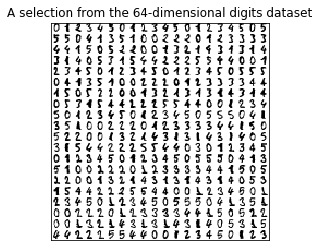

In [15]:
# Loading libraries, data & defining convenience functions (no analysis performed)

from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition)
from scipy.io import wavfile
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import pandas as pd
from scipy import stats

digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30
#----------------------------------------------------------------------
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')
plt.show()

# Convenience functions
#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.tab20(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()

def plot_components(components):
    nComp=components.shape[0]
    fig = plt.figure(figsize=(6, 6))
    nCol=np.ceil(np.sqrt(nComp))
    nRow=np.ceil(nComp/nCol)
    for i in range(nComp):
        ax = fig.add_subplot(nRow,nCol,i+1)
        plt.imshow(components[i,:].reshape(8,8),cmap=plt.cm.binary)
        plt.xticks([])
        plt.yticks([])
        plt.title('Comp. '+str(i+1))
plt.show()

    
def plot_recontruction(weights,basisVecs,avgImg,digitIdxToShow=[0,6,1,7,2,8,3,4,5] ):    
    
    fig = plt.figure(figsize=(15, 15))
    nCol=nComp+2
    nRow=len(digitIdxToShow)+1
    #Plot component images
    ax = fig.add_subplot(nRow,nCol,2)
    plt.imshow(avgImg,cmap=plt.cm.binary)
    plt.title('Offset')
    plt.xticks([])
    plt.yticks([])

    for i in range(nComp):
        ax = fig.add_subplot(nRow,nCol,i+3)
        plt.imshow(basisVecs[i,:].reshape(8,8),cmap=plt.cm.binary)
        plt.title('Comp. '+str(i+1))
        plt.xticks([])
        plt.yticks([])
    for digitNumber in range(len(digitIdxToShow)):
    
        #True Image
        ax = fig.add_subplot(nRow,nCol,(digitNumber+1)*(nCol)+1)
        m=np.min(X[digitIdxToShow[digitNumber],:])
        M=np.max(X[digitIdxToShow[digitNumber],:])
        
        plt.imshow(X[digitIdxToShow[digitNumber],:].reshape(8,8),cmap=plt.cm.binary,vmin=m,vmax=M)
        plt.title('True:'+str(y[digitIdxToShow[digitNumber]]))
        plt.xticks([])
        plt.yticks([]) 
    
        #Average Image
        ax = fig.add_subplot(nRow,nCol,(digitNumber+1)*(nCol)+2)
        img=avgImg #np.zeros((8,8))
        plt.imshow(avgImg,cmap=plt.cm.binary,vmin=m,vmax=M)
        plt.title('1x')
        plt.xticks([])
        plt.yticks([]) 
    
        # Reconstruction
        for component in range(nComp):
            ax = fig.add_subplot(nRow,nCol,(digitNumber+1)*(nCol)+component+3)
            img=img+weights[digitNumber,component]*basisVecs[component,:].reshape(8,8)
            plt.imshow(img,cmap=plt.cm.binary,vmin=m,vmax=M)
            plt.title( str("%+.2f" % round(weights[digitNumber,component],2))+'x')
            plt.xticks([])
            plt.yticks([])    
    plt.show()    
    



## Data:
Our initial examples with be demonstrated on the digits data. These are 8x8 pixel images of handwritten numbers (we restrict ourselves to numbers from 0 to 6). These 8x8 square images are flattened into 64 dimensional vectors and the relative positions of the different 
pixels is effectively discarded. Analysis will be on these 64 dimensional vectors.

### PCA:
Let's perform PCA on these vectors and embed them into 2D (i.e. preserve only the first 2 principal components). Note in the visualization the colored numbers represent the PCA position of an image with the specified number. Sample images for outlier points are shown in the white rectangles.

For the most part, even with a PCA we're able to mostly separate these digit types out!

Computing PCA projection


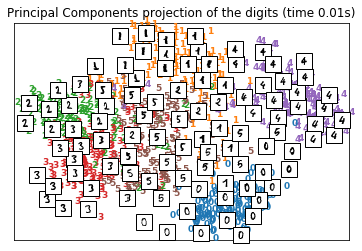

In [2]:
print("Computing PCA projection")
t0 = time()
X_pca = decomposition.PCA(n_components=2).fit_transform(X)
deltaT=(time() - t0)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" % deltaT)


### PCA Basis Vectors & Reconstruction
To get a better understanding of whats going on, lets look at the Principal components used by PCA and how these can be used to reconstruct the images. Since the input vectors have length 64, we have 64 principal components in all. For visualization purposes, we focus on the top 10.

Please run the code below two generate two figures.

The top plot just visualizes the principal components:
* Note how non-localized and spread the digits are.
* They don't really represent a number or a part of a number

Try increasing the number of components from 10. Does this change the top components? Why does this happen?

Shown in the lower plot, is a principal component by component (columns) reconstruction of several sample images (rows). 
* PCA starts with an average image (the second column).
* Individual components add to this image, and as we get more components the closer we get to the image.
* Notice the magnitudes and signs of the components (number in text above image). Can you make sense of why these based on the images? These numbers are the PCA coordinates.

Why is component 1 high in the '0' digits, while component 2 is higly negative? Notice the similar patterns across the same digits. This is what leads to clustering in the PCA scatter plot above.

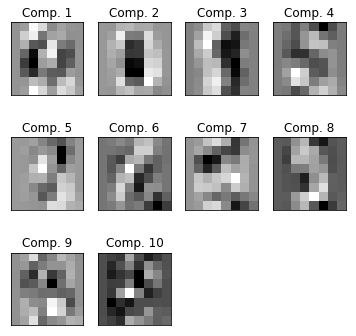

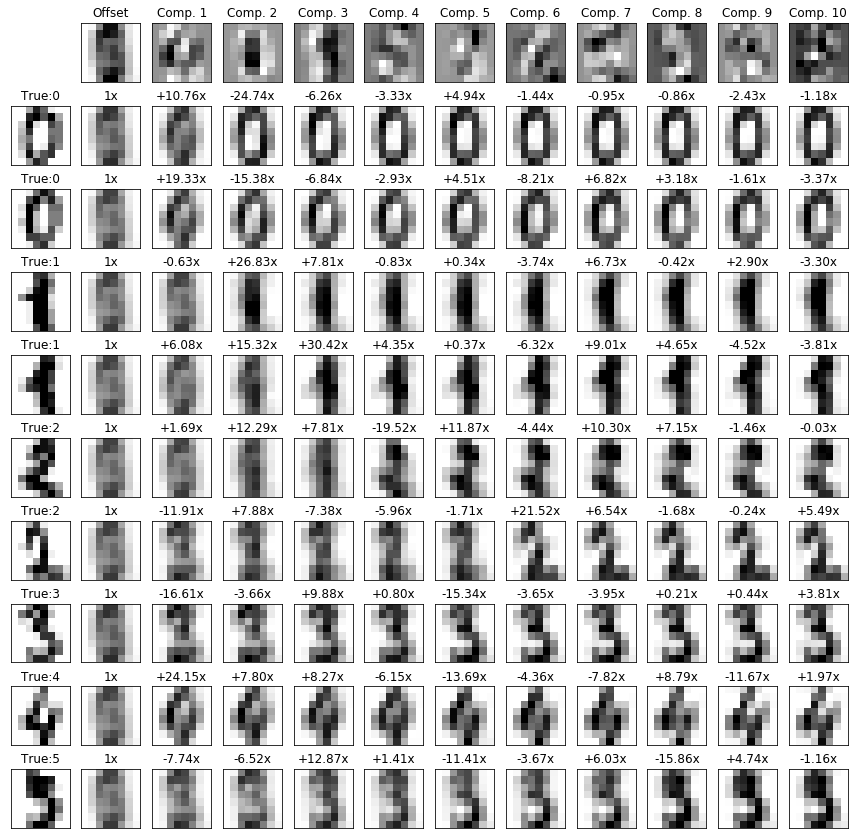

In [16]:
nComp=10
pca=decomposition.PCA(n_components=nComp).fit(X)
pcaComponents=pca.components_
pcaWeights=pca.transform(X)
pcaOffset=pca.mean_.reshape(8,8)

plot_components(pca.components_)

digitIdxToShow=[0,6,1,7,2,8,3,4,5]
plot_recontruction(pcaWeights[digitIdxToShow,:],pcaComponents,pcaOffset,digitIdxToShow=digitIdxToShow )

## NNMF:
Lets repeat the process for NNMF. As for the PCA lets start with a 2-dimensional reduced scatter plot.

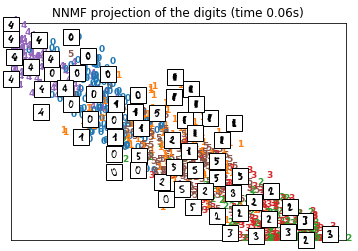

In [4]:
t0 = time()
X_nnmf = decomposition.NMF(n_components=2).fit_transform(X)
deltaT= (time() - t0)
plot_embedding(X_nnmf,
               "NNMF projection of the digits (time %.2fs)" % deltaT)


***Questions***
1. Why does nNMF look so much worse than PCA?
2. Think a little bit about the fact that nNMF is essentially PCA with contraints. What kind of basis vectors do you think we'll get?

Run the code below o find out:

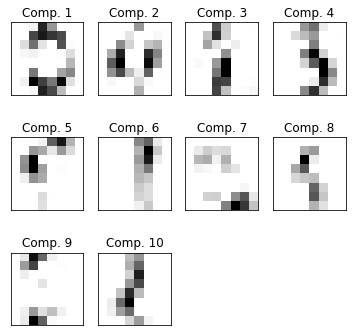

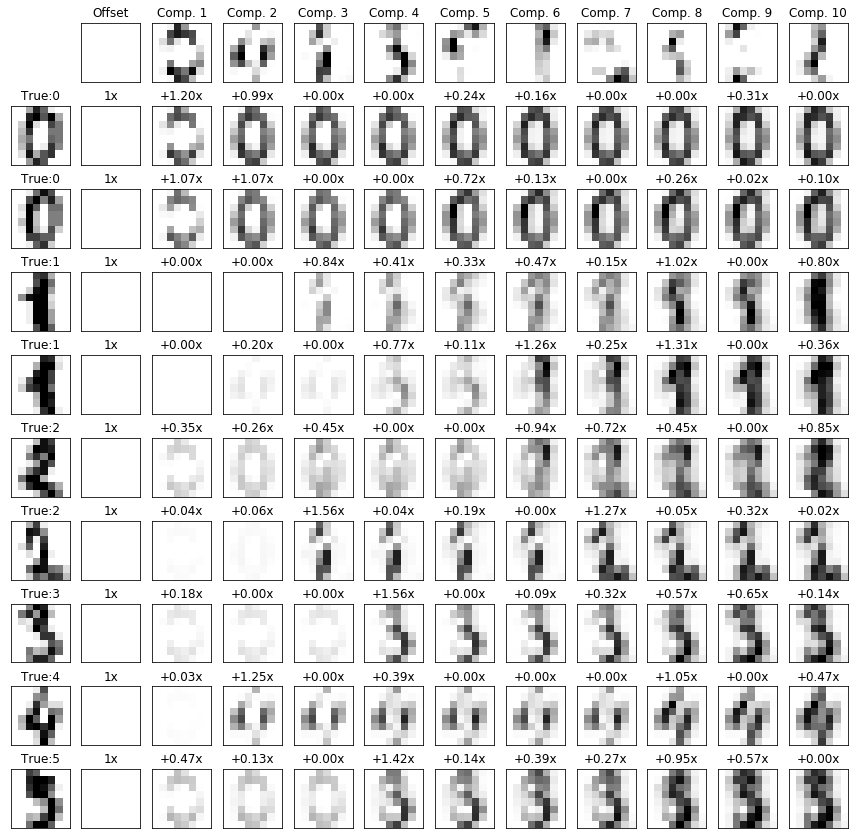

In [17]:
nComp=10
nnmf=decomposition.NMF(n_components=nComp)
nnmfWeights = nnmf.fit_transform(X)
nnmfBasis = nnmf.components_
plot_components(nnmfBasis)
nnmfOffset=np.zeros((8,8))

digitIdxToShow=[0,6,1,7,2,8,3,4,5]
plot_recontruction(nnmfWeights[digitIdxToShow,:],nnmfBasis,nnmfOffset,digitIdxToShow=digitIdxToShow )

*** Questions ***
1. What is the big qualitative difference between the PCA nd nNMF components? Think of the number of non-zero components and how they are distributed spatially. Why do you think nNMF generates more local connected components?
2. In the recontruction, why is the 2nd column pure white? In other words why don't we start with the average image like PCA?
3. In terms of the reconstruction, look at the weights (the numbers above the images). How are these different from PCA in terms of their distribution. How does this emerge from the non-negativity constraint? 
4. Now try changing the number of components `nComp`. How does this change the components and the reconstruction? Why is this behavior different from PCA? What does this mean for convergence with fewer components?


### ICA
Now lets repeat the same procedure with ICA.


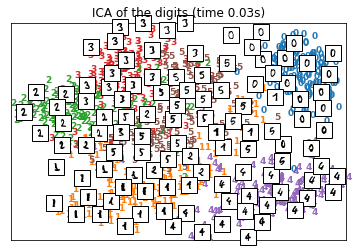

In [6]:
t0 = time()
xICA = decomposition.FastICA(n_components=2).fit_transform(X)
deltaT=(time() - t0)
plot_embedding(xICA,
               "ICA of the digits (time %.2fs)" % deltaT)

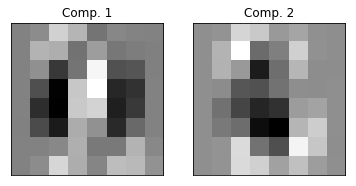

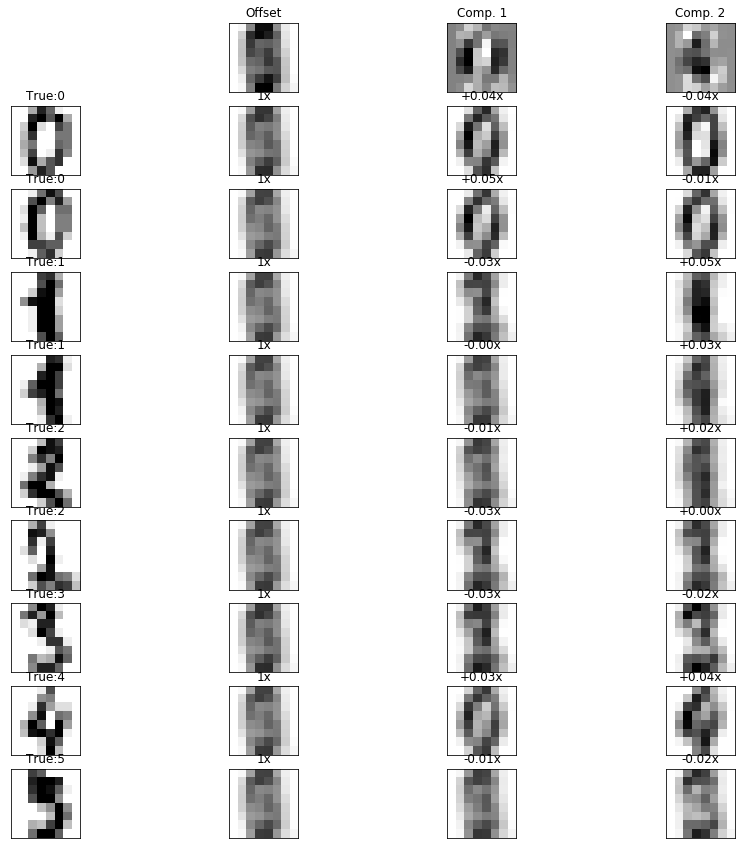

In [25]:
nComp=2
ica=decomposition.FastICA(n_components=nComp,max_iter=1000)
icaWeights = ica.fit_transform(X)
icaBasis = ica.mixing_.T
icaOffset=ica.mean_.reshape(8,8)

plot_components(icaBasis)


digitIdxToShow=[0,6,1,7,2,8,3,4,5]
plot_recontruction(icaWeights[digitIdxToShow,:],icaBasis,icaOffset,digitIdxToShow=digitIdxToShow )

*** Questions ***
1. Do the ICA component resemble PCA or nNMF? Why does thi make sense?
2. How does ICA behacior change with the number of components use?
3. Compare the PCA and ICA results with just 2 components. What does this tell us about how these methods work?

While PCA and ICA have several similarities, their usage scenarios tend to be different. In ICA we are typically looking for independant sources of the signal, while on PCA the focus is on best expressing the data with fewer components.

This distinction is clearer when we do indeed generate our data as a mix of signals. Below we have 3 independant waveforms (sine, rectangular and sawtooth) which we combine in different proportions to generate 3 mixed signals. Compare the reconstruction based on ICA and PCA. Why does this make sense?


Automatically created module for IPython interactive environment


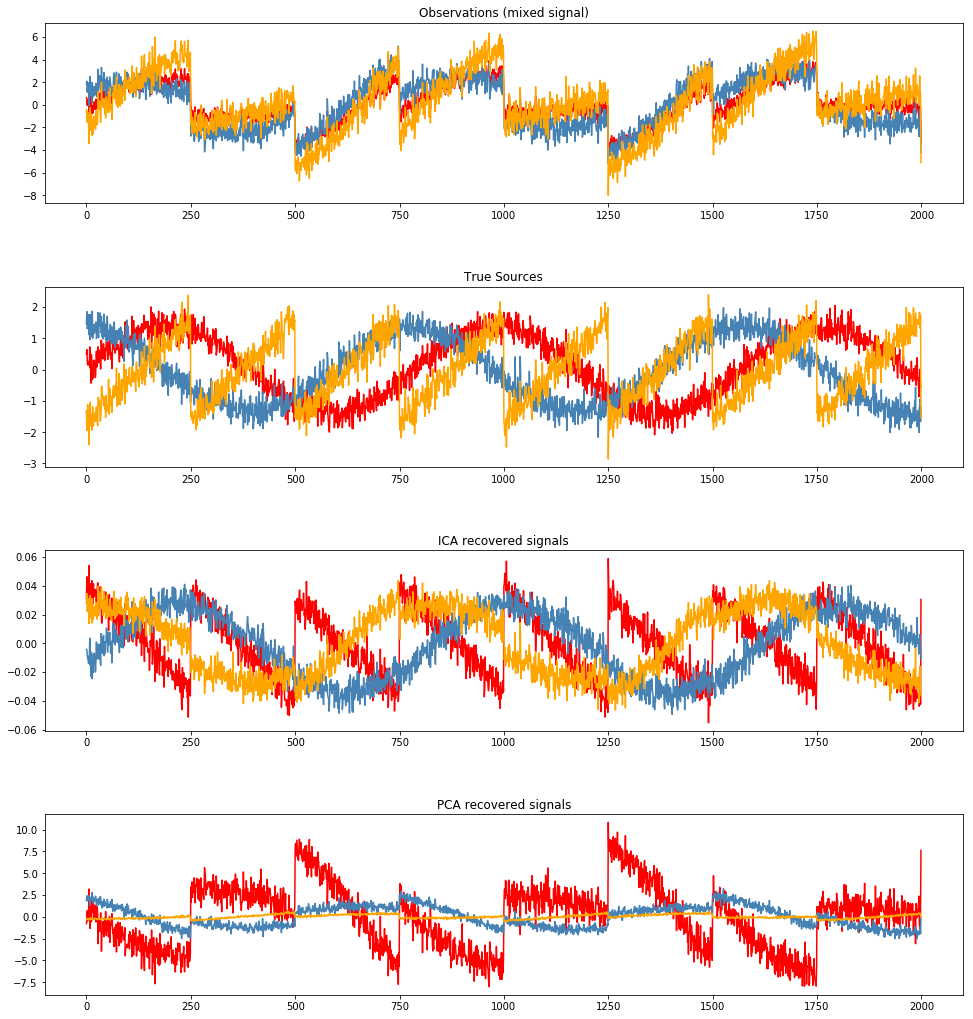

In [26]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA, PCA

# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
timeVals = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * timeVals)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * timeVals))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * timeVals)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise
#S += 0.5 * (np.random.uniform(size=S.shape)-0.5)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X0 = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X0)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X0, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X0)  # Reconstruct signals based on orthogonal components

# #############################################################################
# Plot results

plt.figure(figsize=(15, 15))

models = [X0, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()

## Distance Based Methods
One big difference with distance based methods is that they will not recover individual components, so we cannot perform a reconstruction. So we will essentially just evaluate the dimensional redcution result.

### MDS
Try running with both metric and non-metric MDS. Does this make a difference? How would you quantitatively say which one is better?

Computing MDS embedding
Done. Stress: 11870.313922


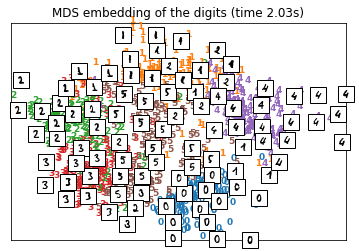

In [29]:
#----------------------------------------------------------------------
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
X_pca = decomposition.PCA(n_components=2).fit_transform(X)
mds = manifold.MDS(n_components=2, n_init=1, max_iter=1000,eps=1E-12,metric=False)
t0 = time()
X_mds = mds.fit_transform(X,init=X_pca)
deltaT=(time() - t0)
print("Done. Stress: %f" % mds.stress_)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" % deltaT )


#### tSNE
Lets look at tSNE results. A couple of things to try:
1. Why do you think we see such sharp cluster here?
2. Try changing the value of perplexity. This affect the definition of neighbors.
3. Repeat for different random seeds (use the second block of code, where we don't initialize using pca). What aspects of the results are well preserved and what are sensitive to random seed? How does this relate to the perplexity and the underlying basis of tSNE.

Computing t-SNE embedding


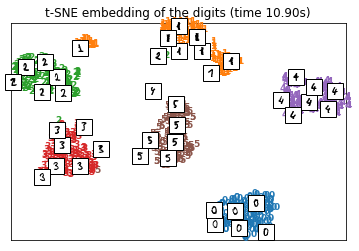

In [35]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
perplexity=30 #Try different values between 5 and 50 (30 is default)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=5,perplexity=perplexity)
t0 = time()
X_tsne = tsne.fit_transform(X)
deltaT=(time() - t0)
plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" % deltaT)


Computing t-SNE embedding


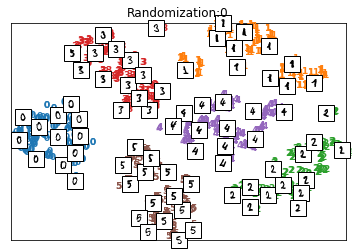

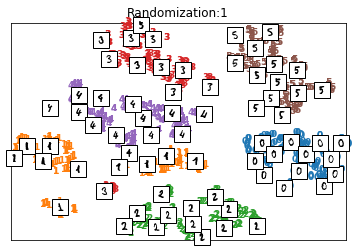

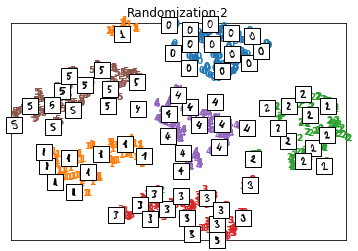

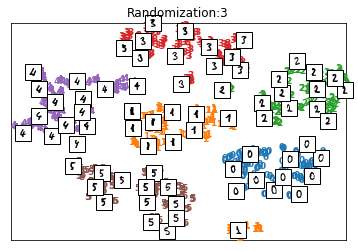

In [12]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
perplexity=5 #Try different values between 5 and 50 (30 is default)
numberOfRandomizations=4;

for randomSeed in range(numberOfRandomizations):

    tsne = manifold.TSNE(n_components=2, random_state=randomSeed, perplexity=perplexity)
    X_tsne = tsne.fit_transform(X)
    plot_embedding(X_tsne,  "Randomization:"+str(randomSeed) )


To get a better handle on the perplexity, lets use the classic swirl data. Try different values of perplexity and see how it affects the results.
Extra:
1. Try running some of the other algorithms like PCA to see what you set.
2. Try adding noise to the data.

t-SNE: 12 sec


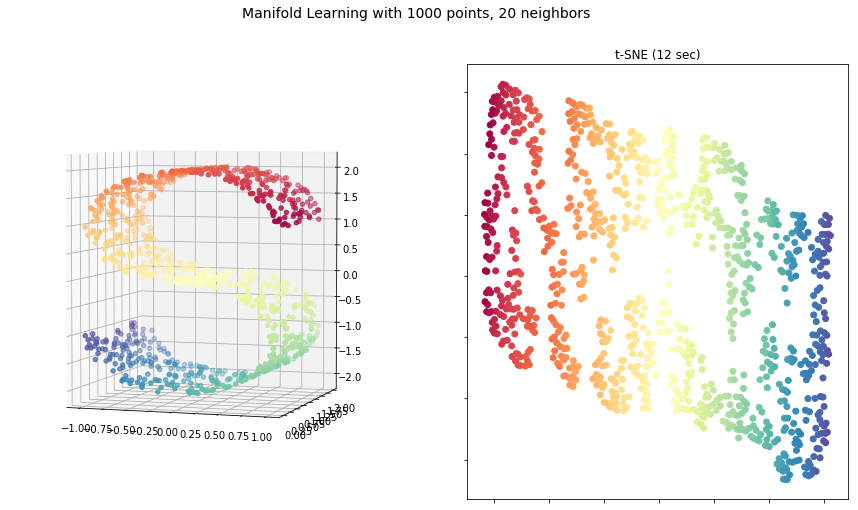

In [36]:
perplexity=30

n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
n_neighbors = 20
n_components = 2
fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

ax = fig.add_subplot(121, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)


t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0, perplexity=perplexity)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(122)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
plt.show()

### Choice of Distance and Data Scaling

An important and overlooked aspect of dimensional reduction is the effect of transformations we perform (or dont!) and the choice of distance measure used.

Lets illustrate this with gene expression data where we do have a sense of what we're measuring. The data set below is RNASeq expression from the GTex consortium that measure expression across a range of tissues. 

Consider two genes, one a high expression gene having ~1000 counts, and another lower expressing with ~100. If both genes expression went down by 50 counts, which do you think is more significant? 

Using a Euclidean distance or directly performing dimensional reduction on the profile vectors treat both sets of changes equally. Thus even using this default is forcing some assumptions on the data!

Below we look at three sets of results:
1. PCA performed on the raw data to (to embed the samples)
2. z-score normalization on a per-gene basis followed by PCA. What does this do in terms of the situation mentioned above? What problems does it potentially introduce?
3. s-xcore normalization, plus filtering out of low expressing genes. Why might we want to do this?

Compare the results below. Do these make sense? Feel free to delve in deeper to explore ...

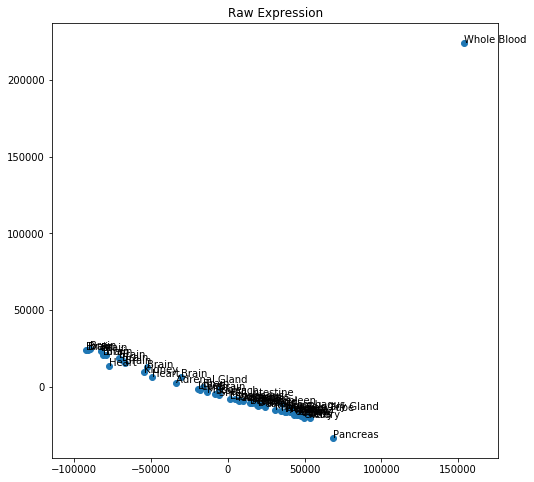

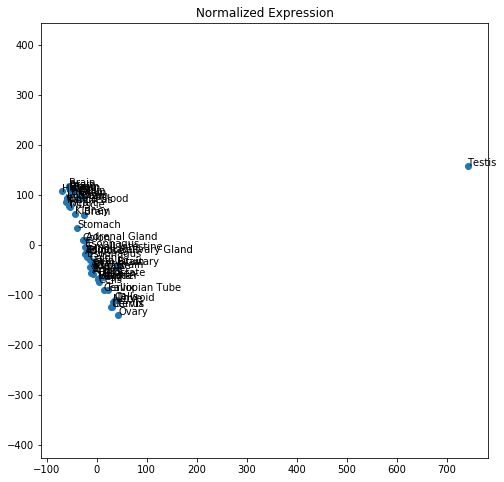

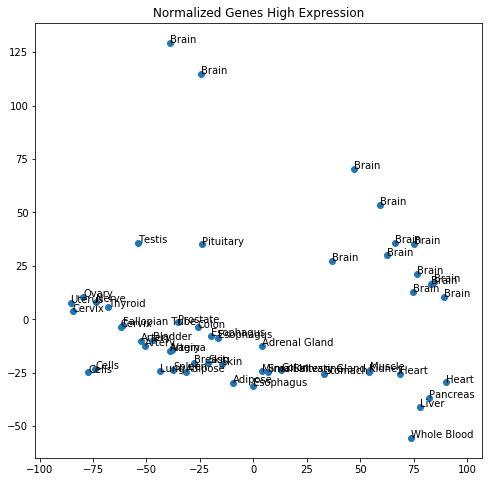

In [14]:
gtexData=pd.read_csv('GTEX_gene_expression.gct',sep='\t',skiprows=2)
gtexExpr=gtexData.iloc[:,2:].values
gtexExprNorm=stats.zscore(gtexExpr[np.std(gtexExpr,axis=1)>0,:],axis=1)
gtexExprNormHi=stats.zscore(gtexExpr[np.logical_and(np.std(gtexExpr,axis=1)>0,
                                                    np.mean(gtexExpr,axis=1)>10) ,:],axis=1)

organs=[]
for col in list(gtexData)[2:]:
    tokens=col.split(" - ")
    organs.append(tokens[0])
gtex=((gtexExpr,'Raw Expression'),(gtexExprNorm,'Normalized Expression'),
      (gtexExprNormHi,'Normalized Genes High Expression'))
for counter,data in enumerate(gtex):
    pca=PCA(n_components=2)
    pcaRes=pca.fit_transform(np.transpose(data[0]))
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(pcaRes[:,0],pcaRes[:,1])
    for counter,name in enumerate(organs):
        plt.text(pcaRes[counter,0],pcaRes[counter,1],name)
    plt.title(data[1])  
    plt.axis('equal')
    plt.show()    


#### Alternate Distance Measures

A fundamental limitation in the standard distance measures is that all the components are treated as equal (which normalization adresses) and un-related (which normalization does not address). 

For example, in our treatment of the digits, we have completely lost the spatial relationship between the pixels. In assessing image similarity if we swapped two neighboring pixels, that is definitely not the same as two pixels at opposite ends of the image. Additionally, directly comparing components as above only works if the digits are well aligned. What would we do if there were random rotations? We could have similar issues in the gene expression case, where changes to genes from similar pathways are perhaps less likely to be functionally relevant that genes in different pathways. 

How can we incorporate some of this information? Can you prototype a new similarity metric or image transformation that might solve some of these issues?


